# Unsupervised learning: PCA and clustering

In [24]:
import numpy as np
import pandas as pd
from sklearn import datasets, decomposition

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## PCA

In [2]:
# Load the iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

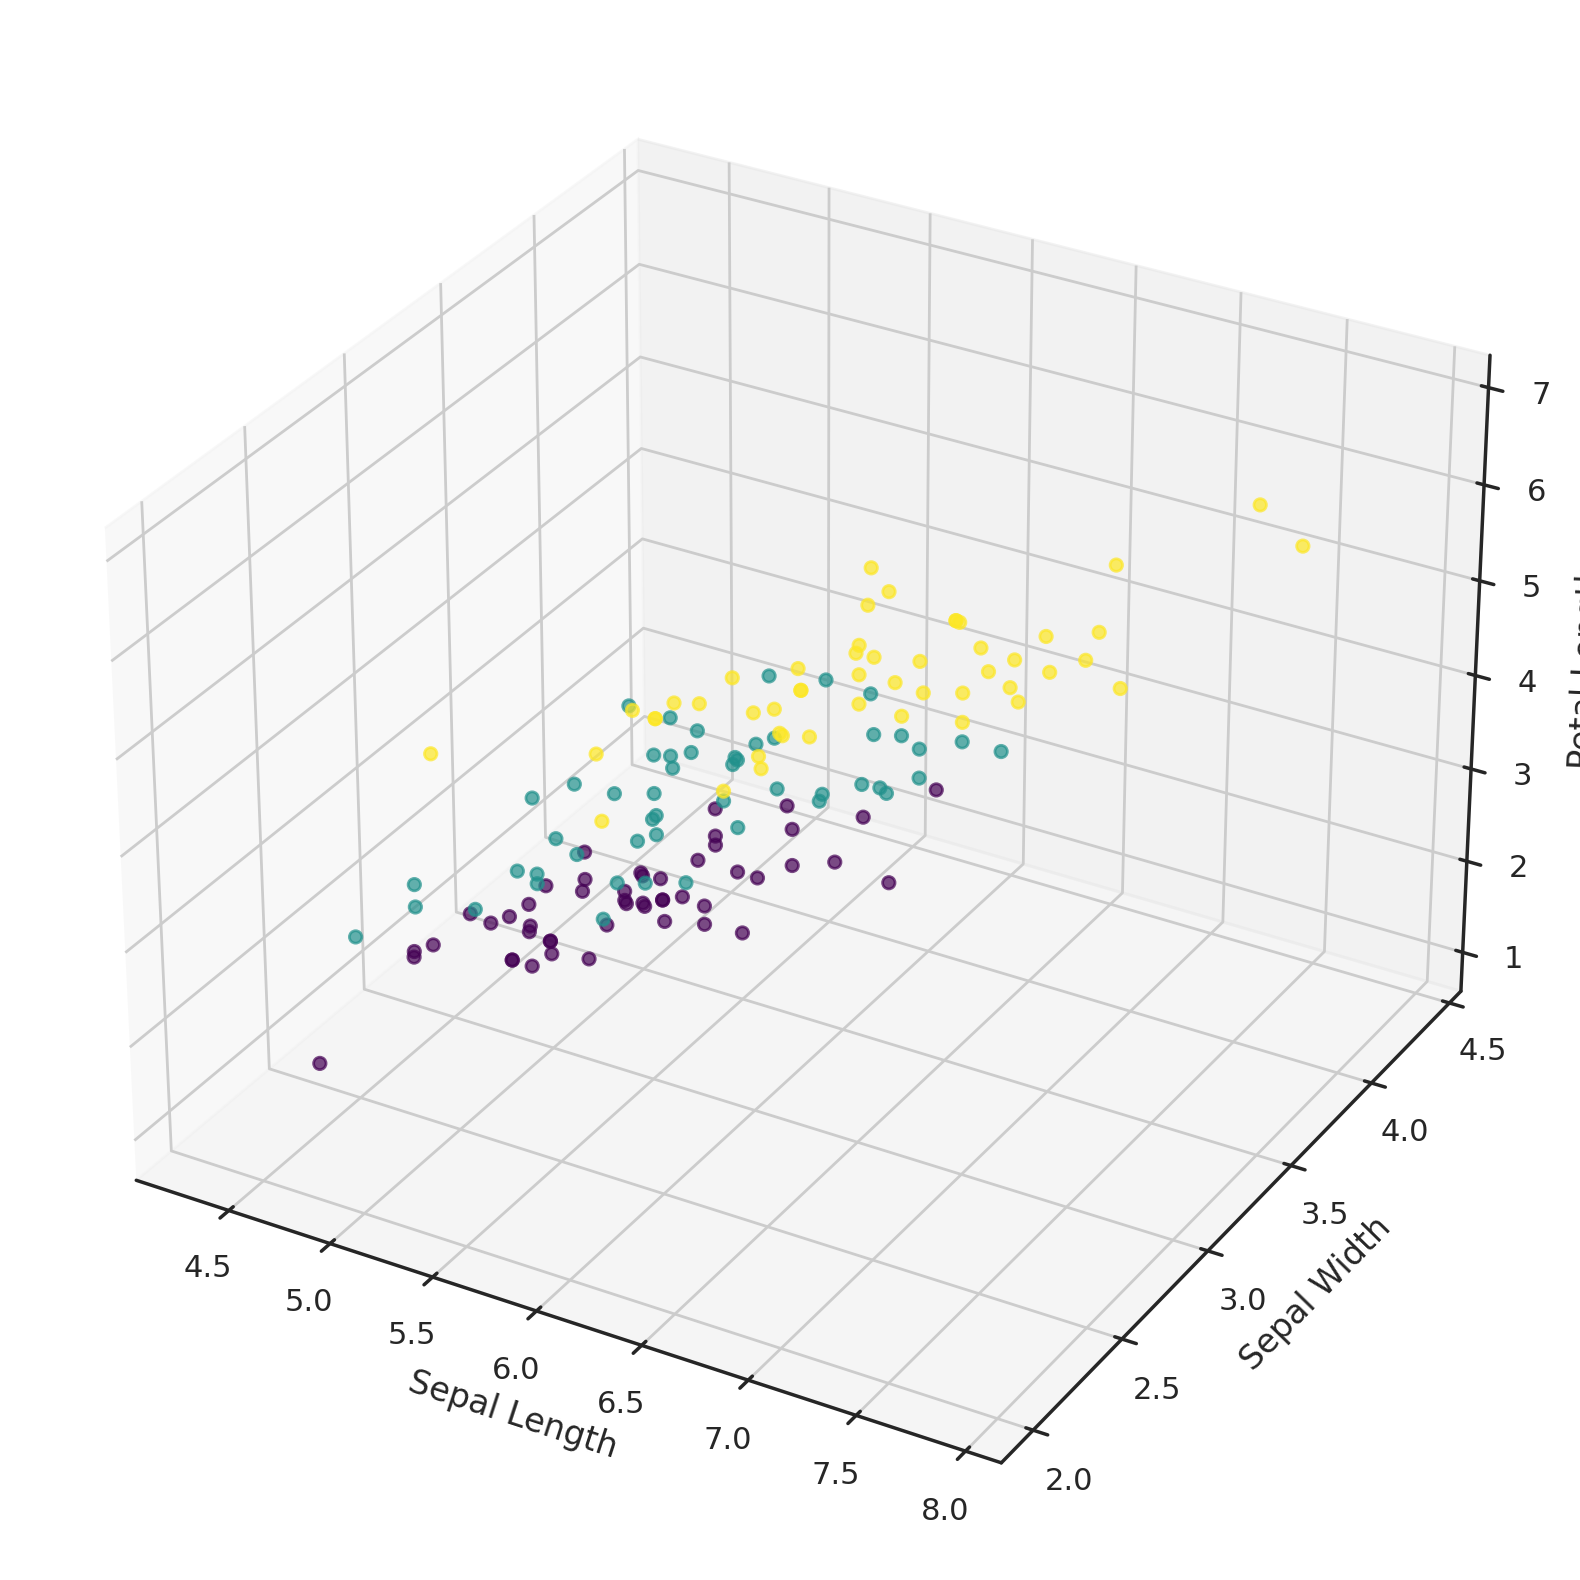

In [3]:
# Plot the dataset in 3D ignoring Petal Width
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2],  
           c=y, cmap='viridis', alpha=0.7)
ax.set_xlabel('Sepal Length')
ax.set_ylabel('Sepal Width')
ax.set_zlabel('Petal Length');

Now let’s see how PCA will improve the results of a simple model that is not able to correctly fit all of the training data:

In [5]:
# Train, test splits
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

In [6]:
# Decision trees with depth = 2
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)

preds = clf.predict_proba(X_test)
print("Accuracy: {:.5f}".format(accuracy_score(y_test, preds.argmax(axis=1))))

Accuracy: 0.88889


Let’s try this again, but, this time, let’s reduce the dimensionality to 2 dimensions:

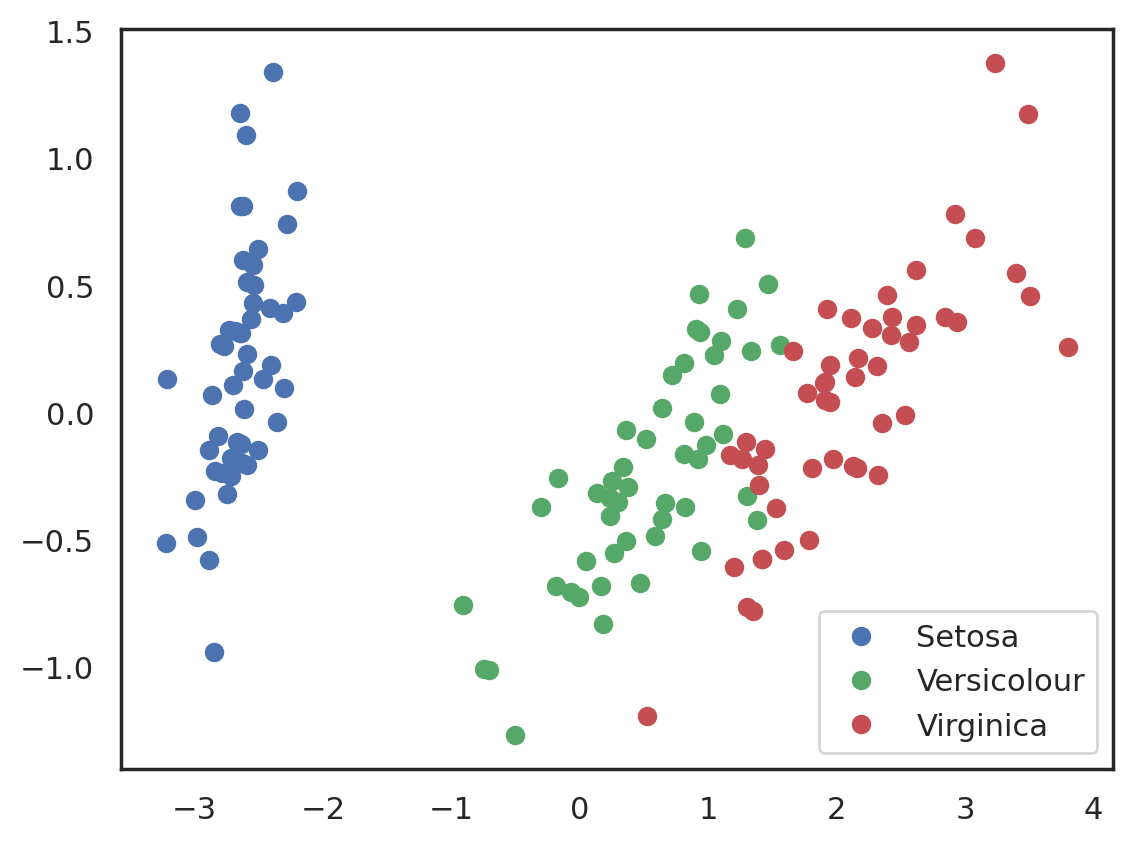

In [7]:
# Using PCA from sklearn PCA
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# Plotting the results of PCA
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], "bo", label="Setosa")
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], "go", label="Versicolour")
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], "ro", label="Virginica")
plt.legend(loc=0);

In [8]:
# Test-train split and apply PCA
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, stratify=y, random_state=42
)

clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print("Accuracy: {:.5f}".format(accuracy_score(y_test, preds.argmax(axis=1))))

Accuracy: 0.91111


Now let’s check out the percent of variance that can be explained by each of the selected components.

In [9]:
for i, component in enumerate(pca.components_):
    print(
        "{} component: {}% of initial variance".format(
            i + 1, round(100 * pca.explained_variance_ratio_[i], 2)
        )
    )
    print(
        " + ".join(
            "%.3f x %s" % (value, name)
            for value, name in zip(component, iris.feature_names)
        )
    )

1 component: 92.46% of initial variance
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
2 component: 5.31% of initial variance
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


### Handwritten numbers dataset

Let’s look at the handwritten numbers dataset that we used before in the 3rd lesson.

In [12]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

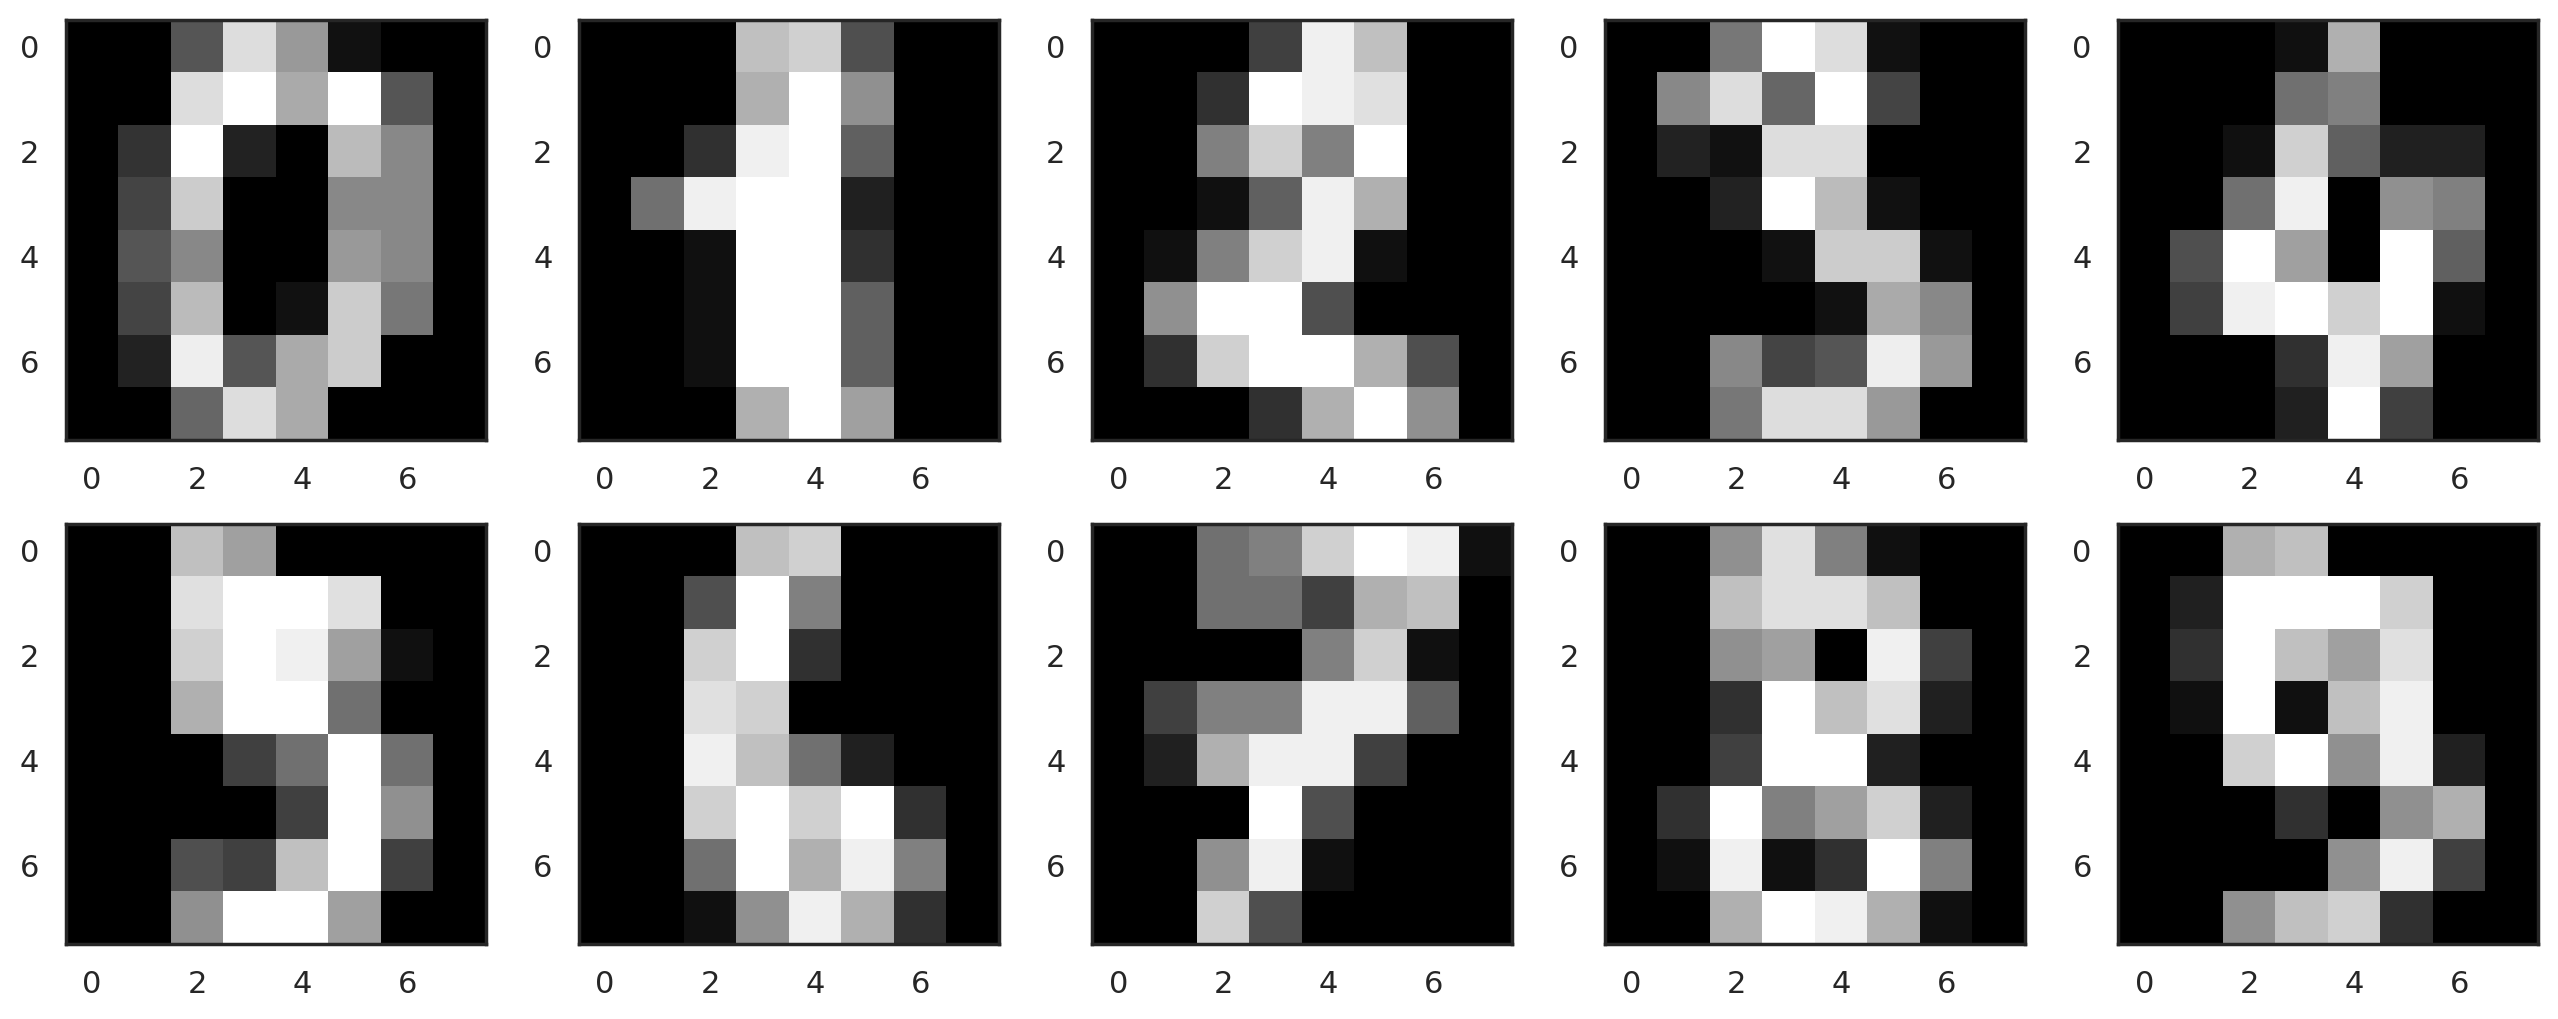

In [13]:
# f, axes = plt.subplots(5, 2, sharey=True, figsize=(16,6))
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i, :].reshape([8, 8]), cmap="gray");

Projecting 64-dimensional data to 2D


/tmp/ipykernel_550743/1923420135.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("nipy_spectral", 10),


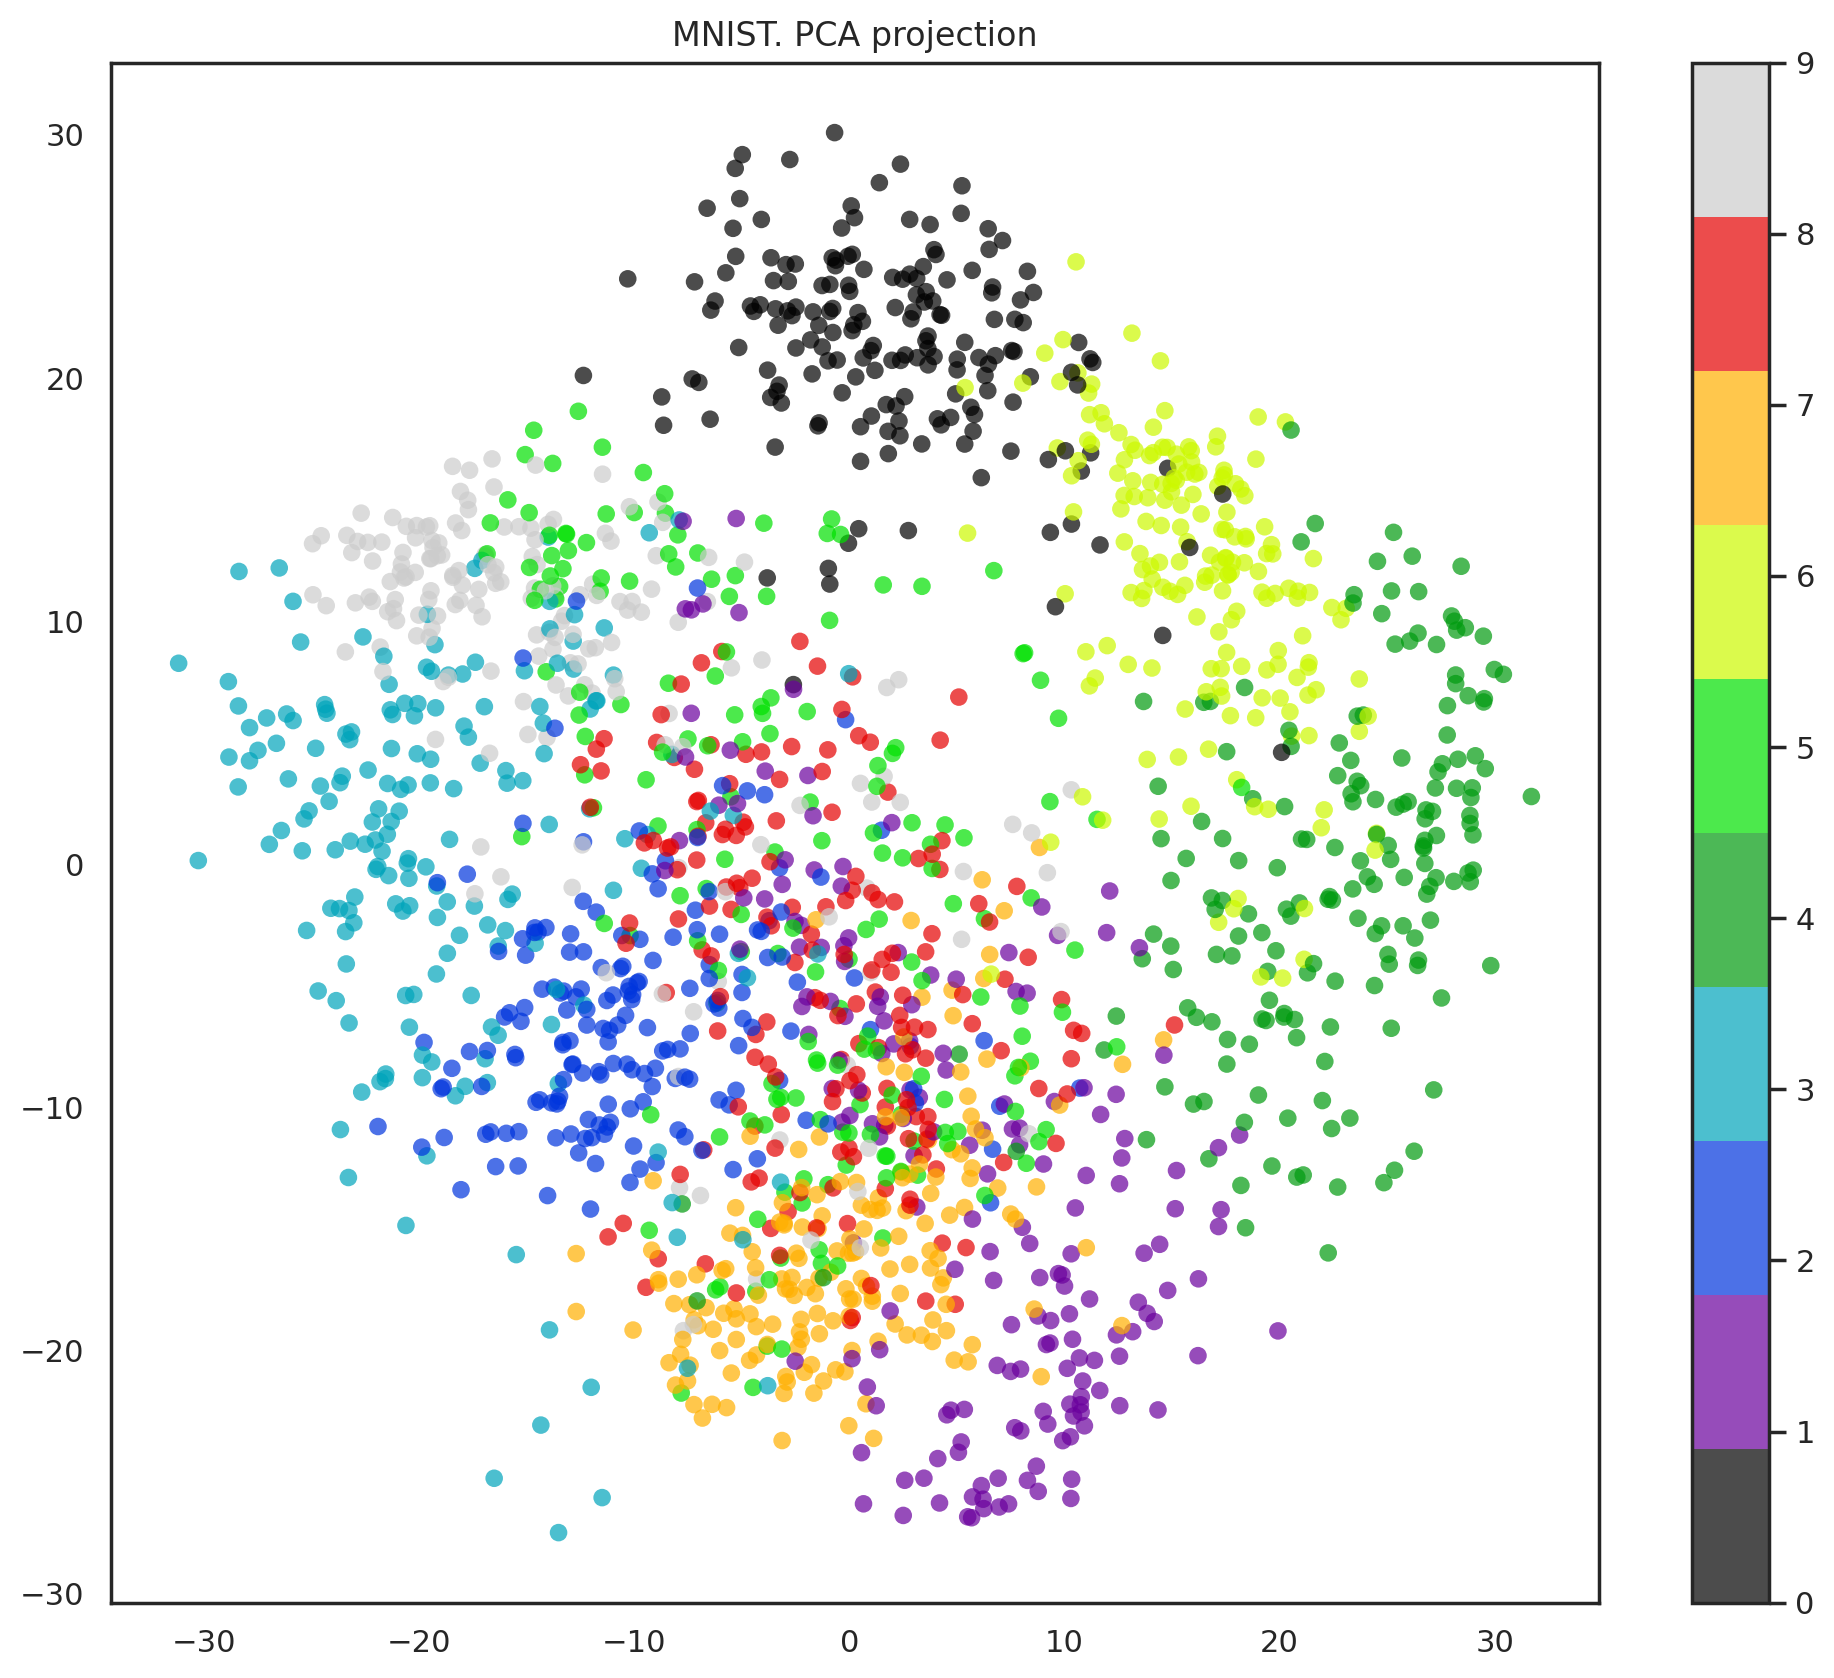

In [14]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print("Projecting %d-dimensional data to 2D" % X.shape[1])

plt.figure(figsize=(12, 10))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=y,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar()
plt.title("MNIST. PCA projection");

Indeed, with t-SNE, the picture looks better since PCA has a linear constraint while t-SNE does not. However, even with such a small dataset, the t-SNE algorithm takes significantly more time to complete than PCA.

<timed exec>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


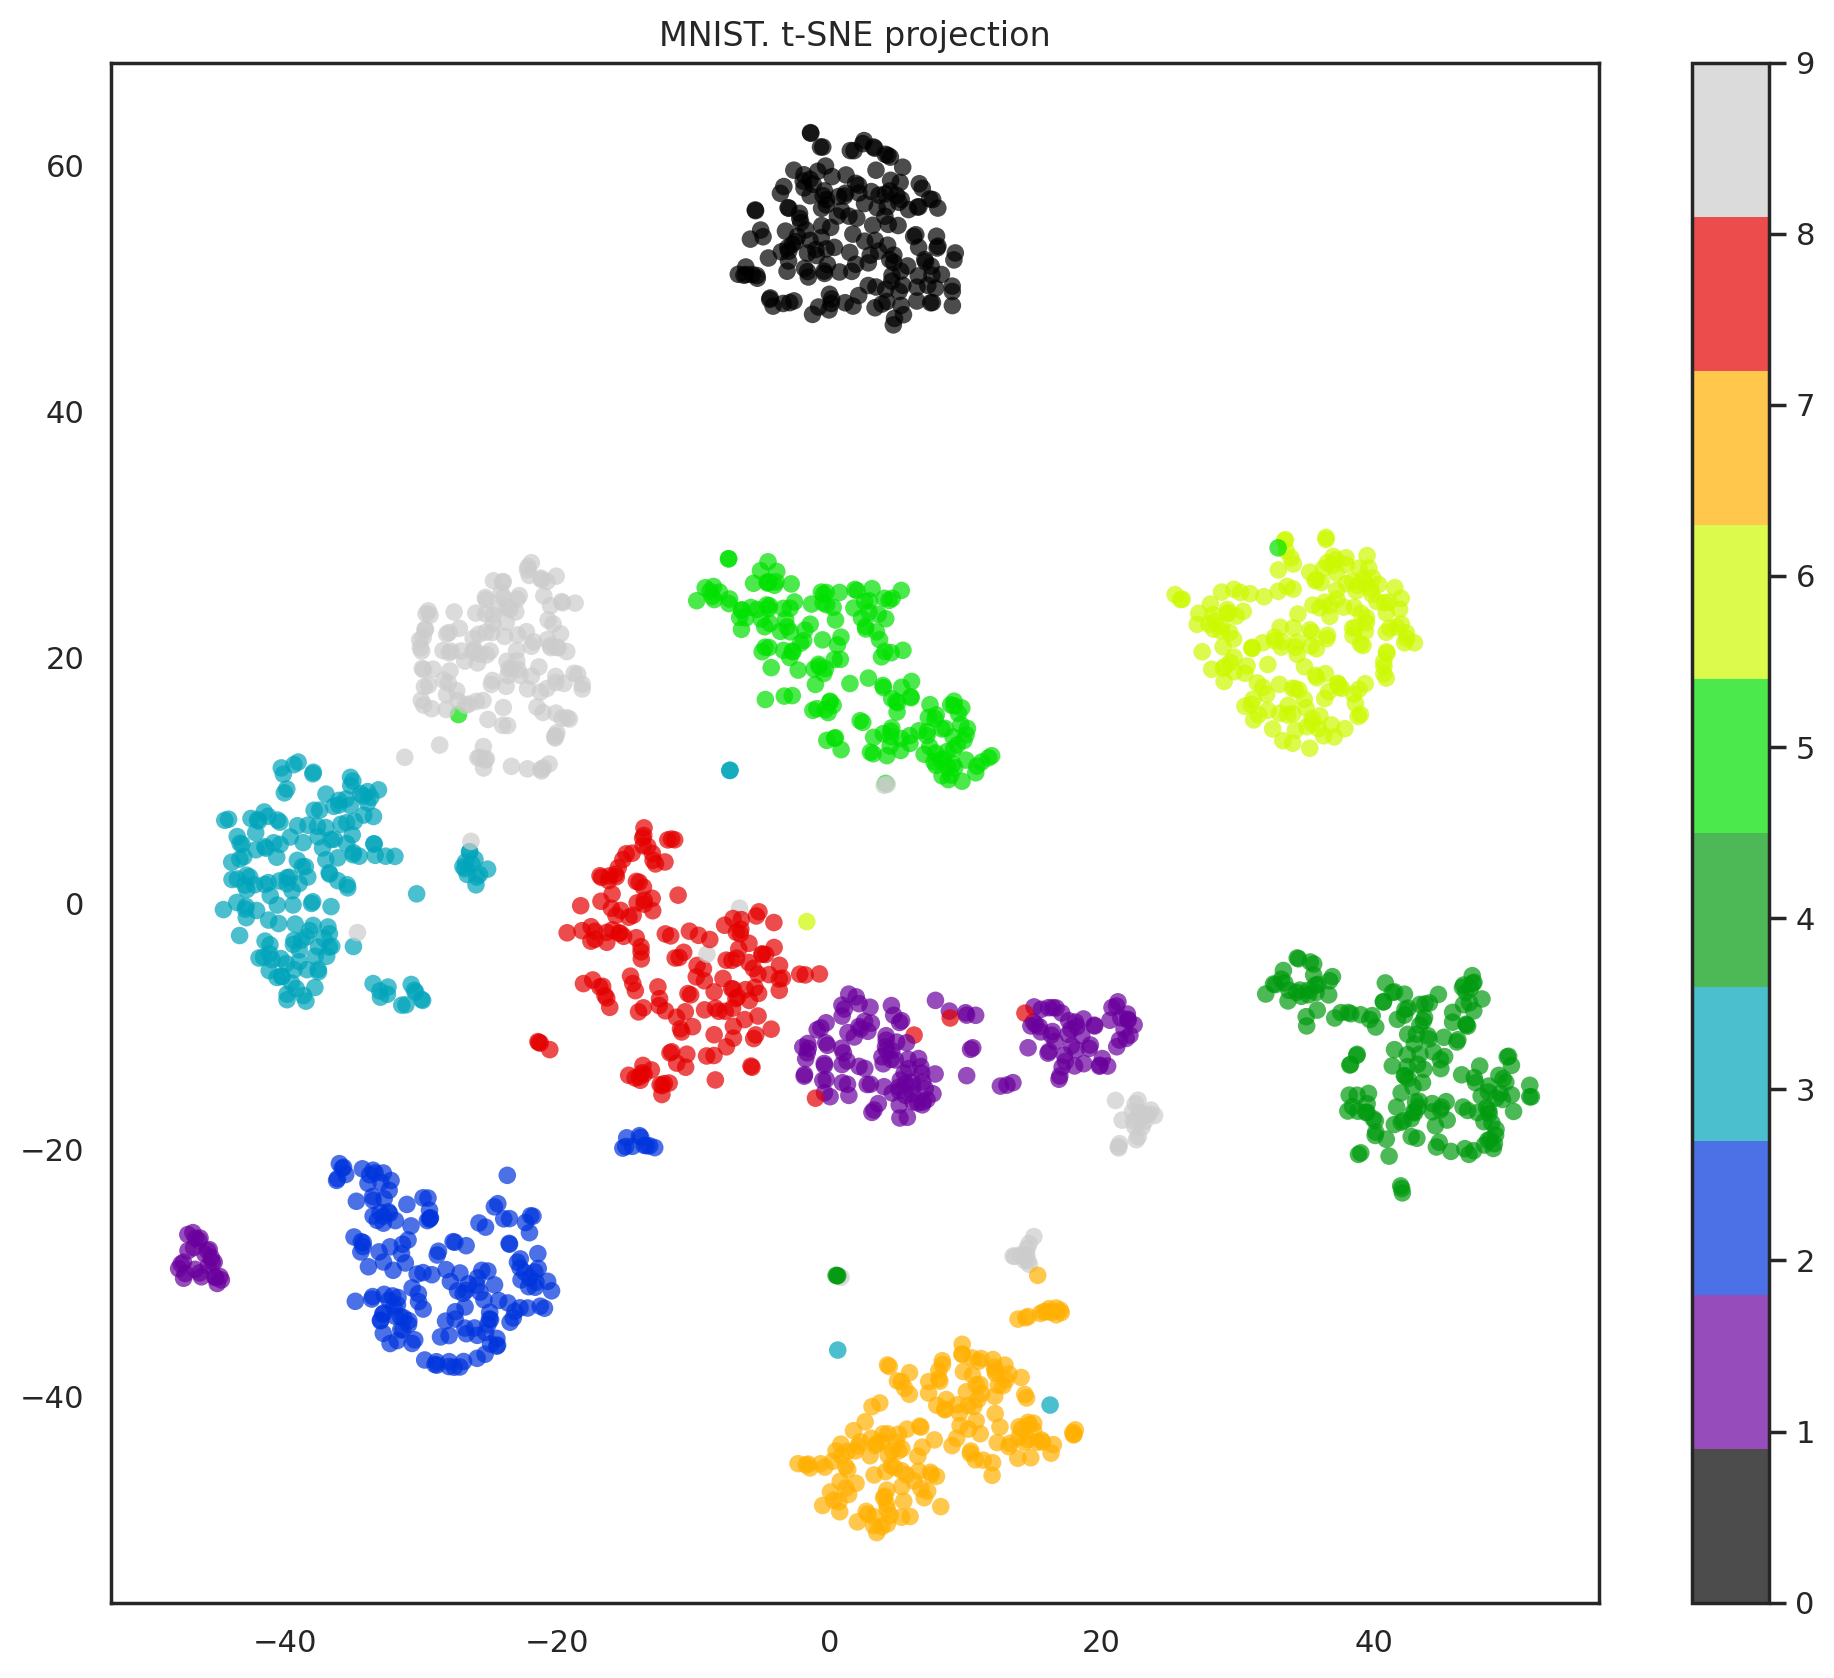

CPU times: user 30.5 s, sys: 404 ms, total: 30.9 s
Wall time: 10.1 s


In [18]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12, 10))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar()
plt.title("MNIST. t-SNE projection")
plt.show()

In practice, we would choose the number of principal components such that we can explain 90% of the initial data dispersion (via the `explained_variance_ratio`). Here, that means retaining 21 principal components; therefore, we reduce the dimensionality from 64 features to 21.

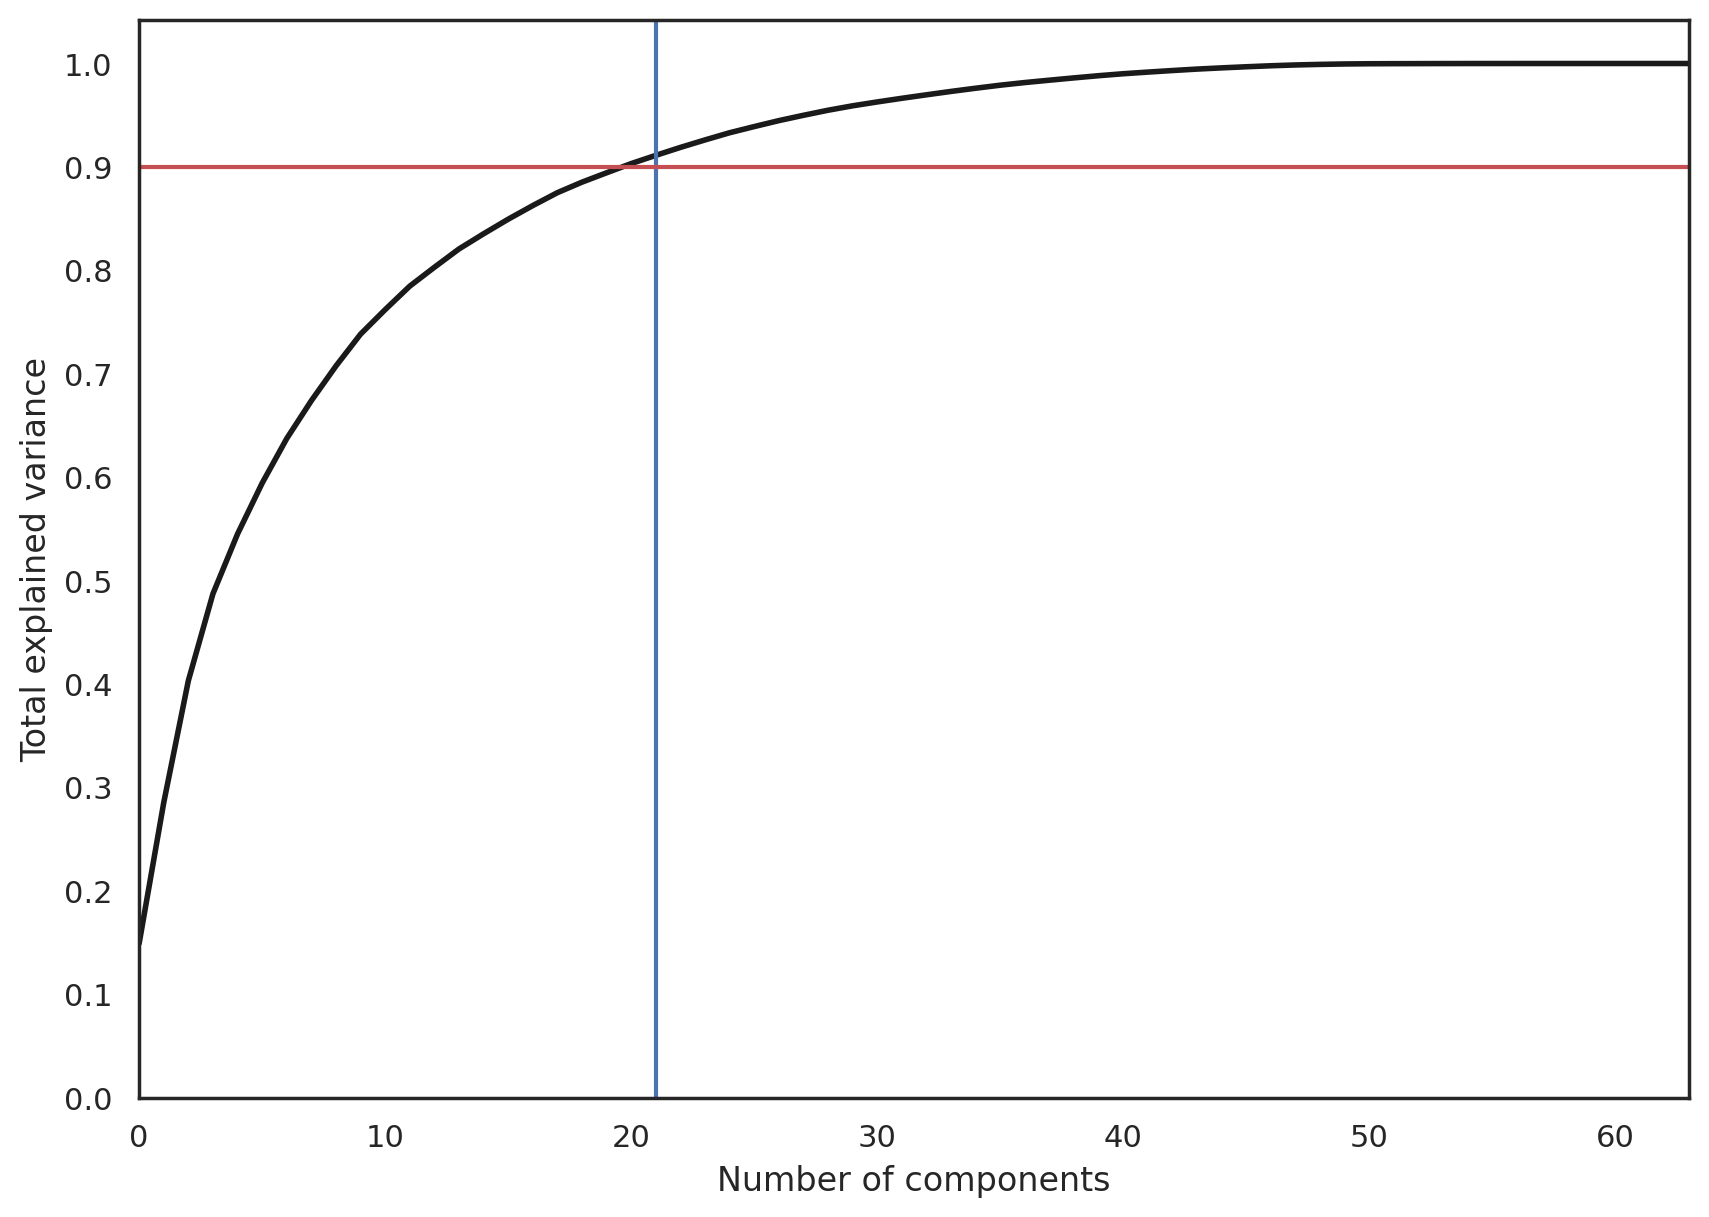

In [20]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color="k", lw=2)
plt.xlabel("Number of components")
plt.ylabel("Total explained variance")
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c="b")
plt.axhline(0.9, c="r")
plt.show();

## Clustering

### K-means

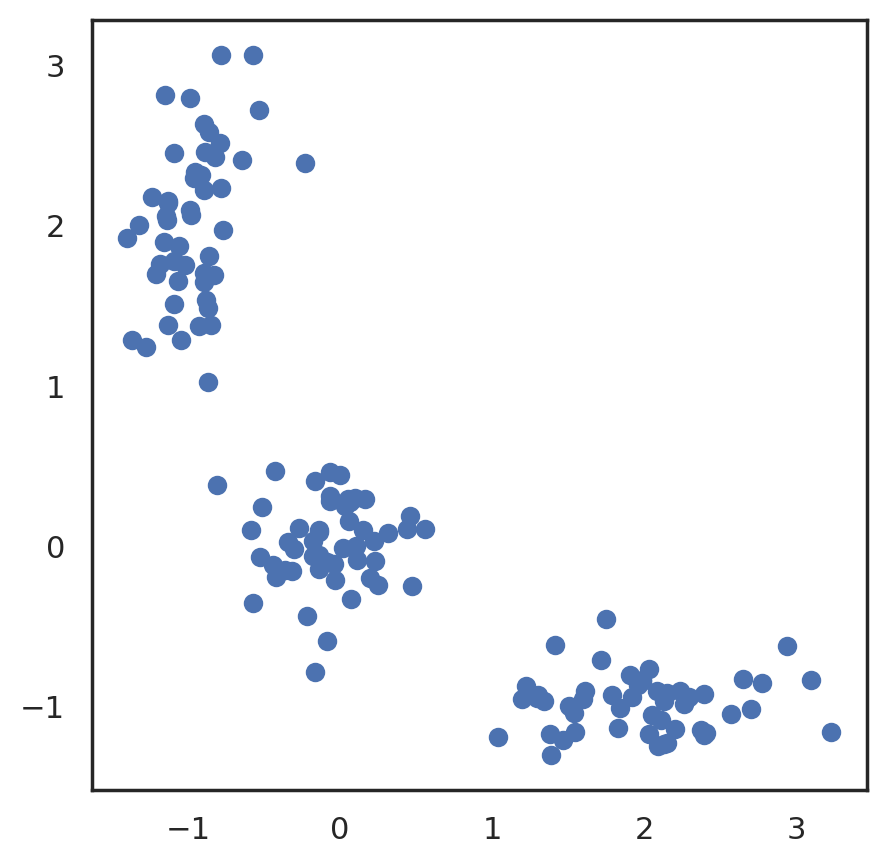

In [21]:
# Let's begin by allocation 3 cluster's points
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=0.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=0.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=0.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=0.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=0.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=0.5, size=50)

plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], "bo");

In [22]:
# Scipy has function that takes 2 tuples and return
# calculated distance between them
from scipy.spatial.distance import cdist

# Randomly allocate the 3 centroids
np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1.0, size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Calculating the distance from a point to a centroid
    distances = cdist(X, centroids)
    # Checking what's the closest centroid for the point
    labels = distances.argmin(axis=1)

    # Labeling the point according the point's distance
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)

    cent_history.append(centroids)

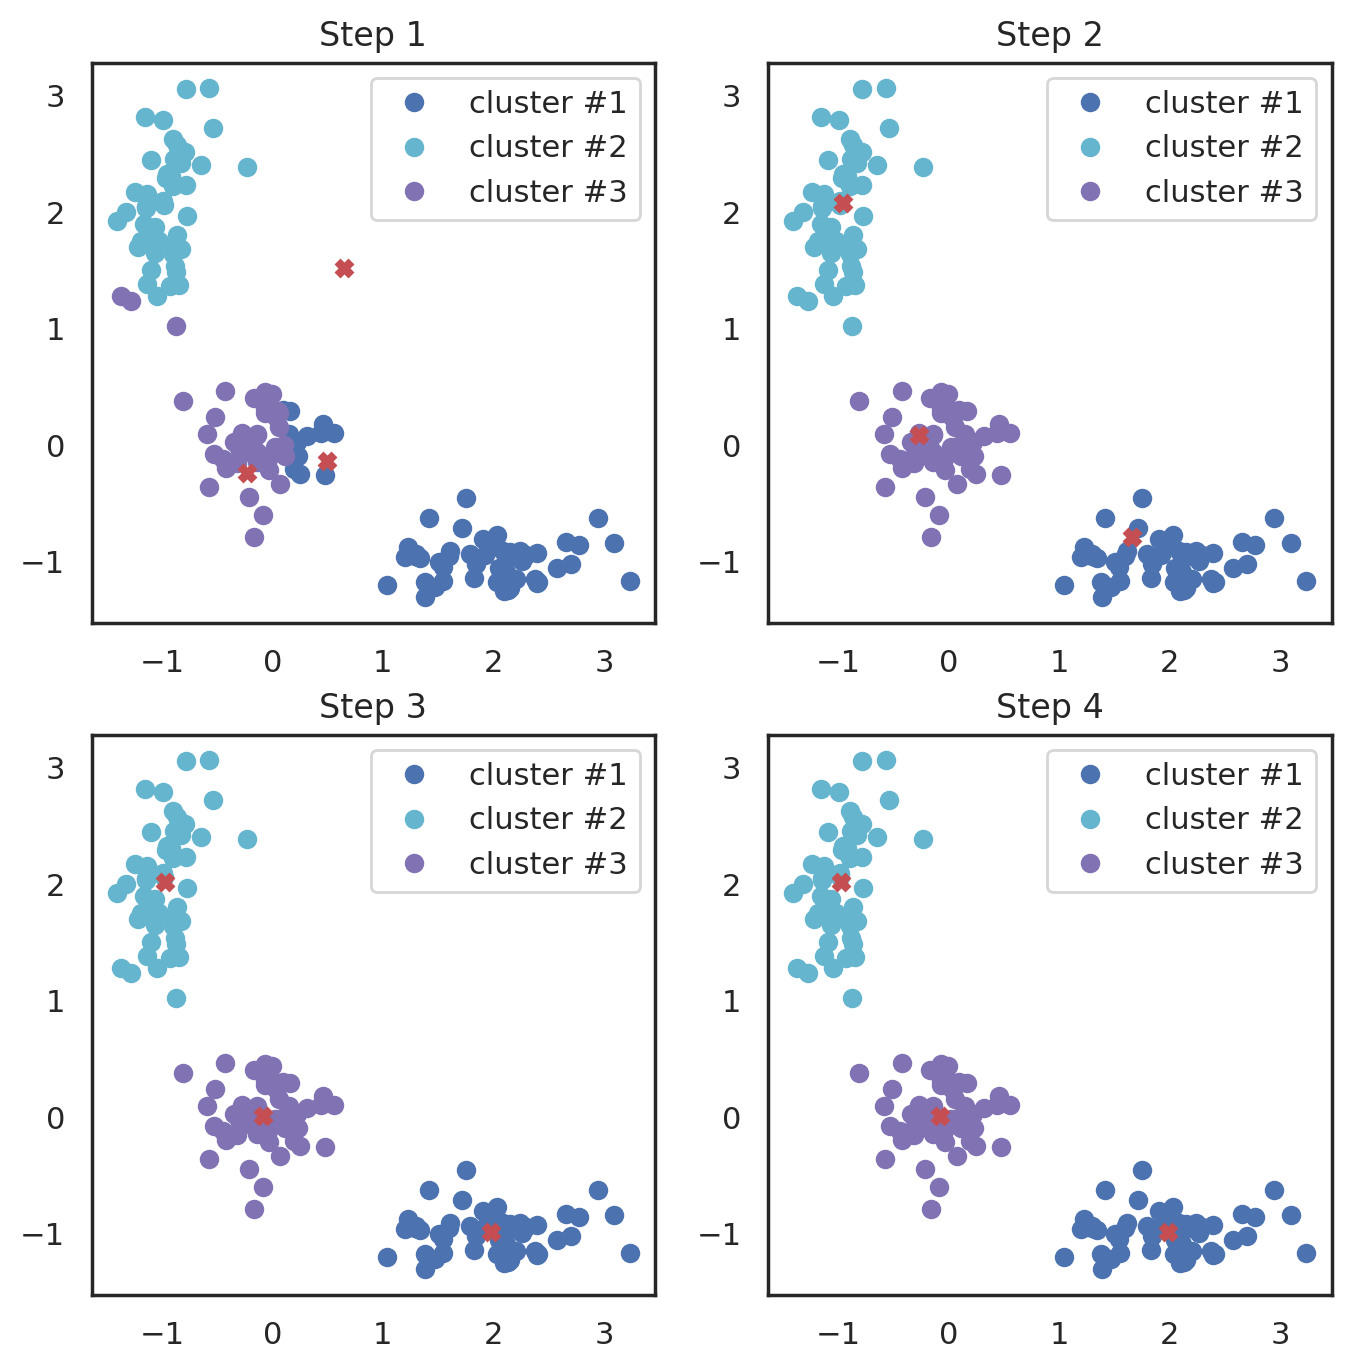

In [23]:
# Let's plot K-means
plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)

    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], "bo", label="cluster #1")
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], "co", label="cluster #2")
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], "mo", label="cluster #3")
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], "rX")
    plt.legend(loc=0)
    plt.title("Step {:}".format(i + 1));

#### Choosing the number of clusters for K-means

In [25]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init='auto').fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

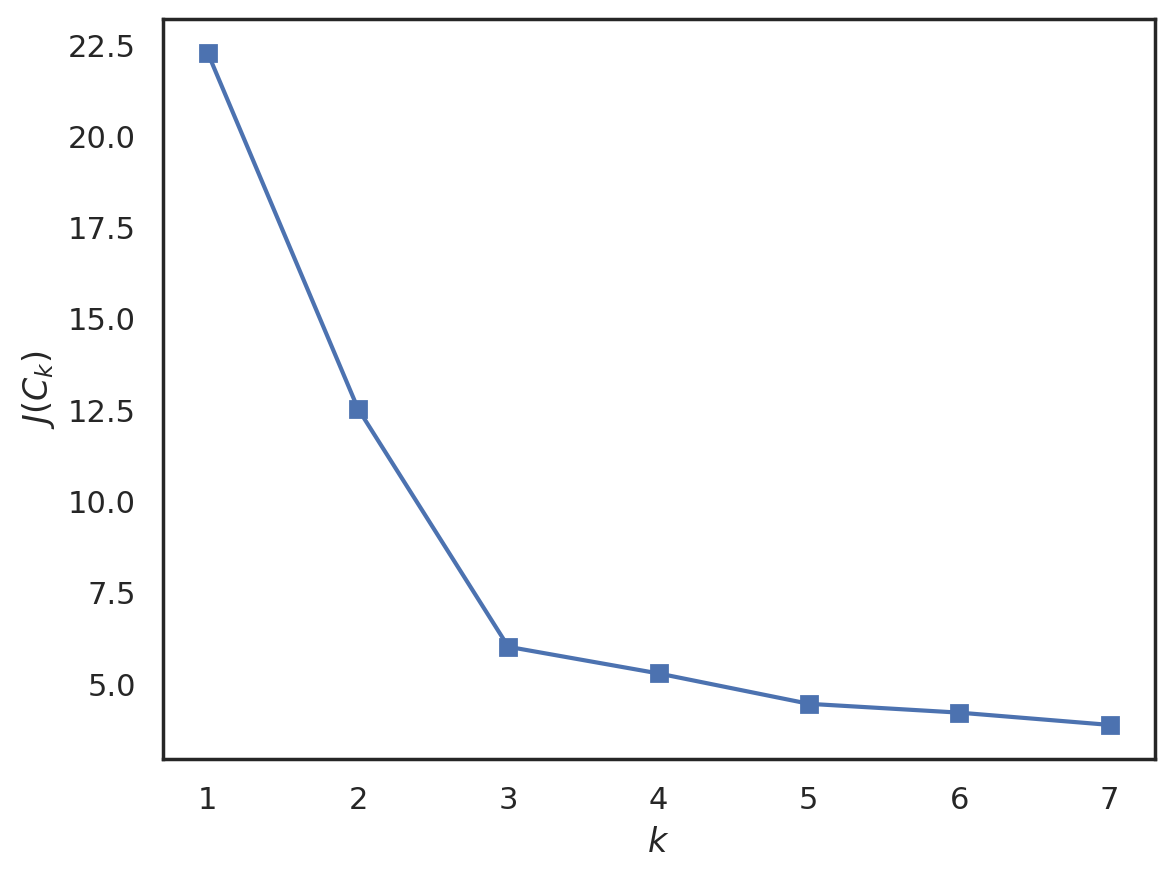

In [26]:
plt.plot(range(1, 8), inertia, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$");

## Agglomerative clustering

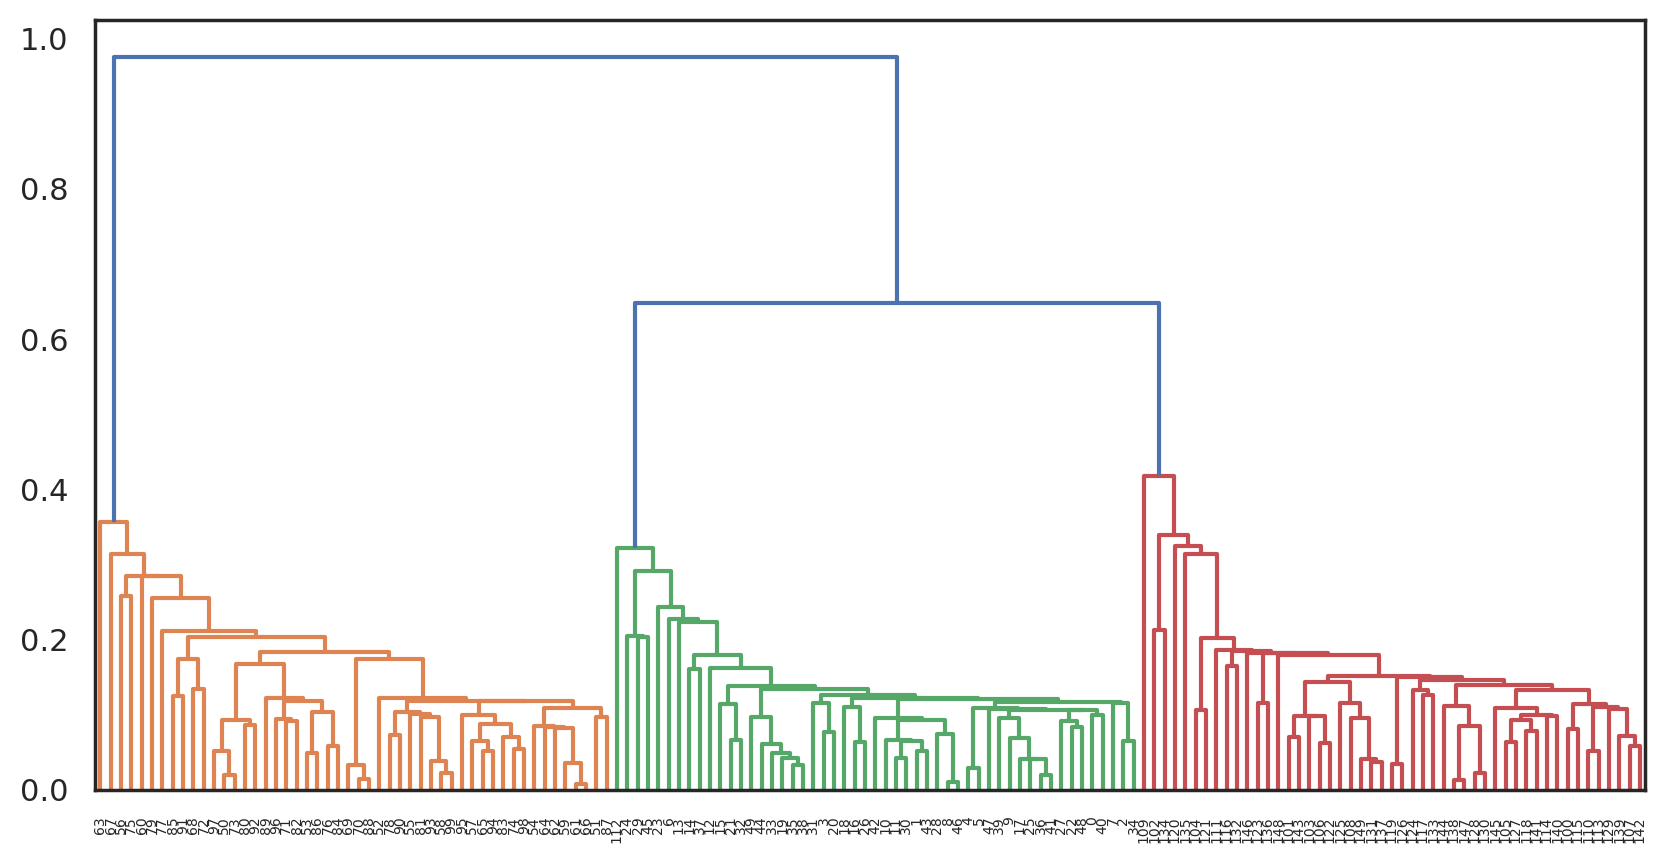

In [27]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=0.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=0.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=0.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=0.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=0.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=0.5, size=50)

# pdist will calculate the upper triangle of the pairwise distance matrix
distance_mat = pdist(X)
# linkage — is an implementation of agglomerative algorithm
Z = hierarchy.linkage(distance_mat, "single")
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)